In [1]:
import numpy as np
import matplotlib.pyplot as plt
from aeons.utils import *
from aeons.regress import *
from aeons.endpoint import *
from aeons.plotting import *
from aeons.beta import *
figsettings()

Will never overestimate dimensionality for Gaussian

Picked Bayesian MD because it is better for other likelihoods

Find why low live points don't work well

Explain bias in dimensionality estimation at low numbers of live points
- Possibly because of poor coverage in all dimensions?
- Sounds like a sampling problem



Text(0.5, 0.98, 'd = 32')

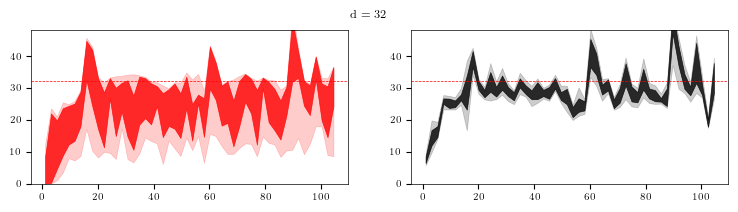

In [132]:
name, samples = get_samples('gauss_32')
iterations_grad, *d_Gs_grad = read_from_txt(f'{data_dir}/d_Gs/grad/{name}.txt')
iterations_logL, *d_Gs_logL = read_from_txt(f'{data_dir}/d_Gs/logL/{name}.txt')
iterations_post, *d_Gs_post = read_from_txt(f'{data_dir}/d_Gs/post/{name}.txt')
d_Gs_grad, d_Gs_logL, d_Gs_post = np.array(d_Gs_grad), np.array(d_Gs_logL), np.array(d_Gs_post)
logXs_grad = samples.logX().iloc[iterations_grad]
logXs_logL = samples.logX().iloc[iterations_logL]
logXs_post = samples.logX().iloc[iterations_post]

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(9, 2))
plot_quantiles(-logXs_post, d_Gs_post, samples.d_G(), ylim=(0, 1.5), ax=ax, color='red', label='Bayesian')
# plot_quantiles(-logXs_logL, d_Gs_logL, samples.d_G(), ylim=(0, 1.5), ax=ax, color='orange', label='Canonical')
plot_quantiles(-logXs_grad, d_Gs_grad, samples.d_G(), ylim=(0, 1.5), ax=ax1, color='black', label='Microcanonical')
fig.suptitle('d = 32')
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[::-1], labels[::-1], ncol=3, bbox_to_anchor=(1.05, -0.4))
# ax.set_xlabel(r'$-\log X$')
# ax.set_ylabel(r'$d_G$', rotation=0, labelpad=10)
# ax.set_title('Intermediate dimension for spherical 32-d Gaussian')
# fig.savefig('d_G_spherical.pdf', bbox_inches='tight', pad_inches=0)

In [65]:
name, samples = get_samples('rosenbrock_10')
model = EndModel(samples)
true_endpoint = model.true_endpoint()
logXf_true = samples.logX().iloc[true_endpoint]

N_points = 50
Nset = 25
iterations = make_iterations(true_endpoint, N_points)
logXs = samples.logX().iloc[iterations]

In [ ]:
def get_beta_end(points, ndead, epsilon=1e-3):
    logX = points.logX()
    logL = points.logL
    # Check if already terminated
    logw = logL + logX
    w = np.exp(logw - logw.max())
    Zdead = np.sum(w[:ndead])
    Zlive = np.sum(w[ndead:])
    if (Zdead != 0):
        if (Zlive/Zdead < epsilon):
            return 1
    # Otherwise, find beta
    def func(beta):
        logw = beta * logL + logX
        w = np.exp(logw - logw.max())
        Zdead = np.sum(w[:ndead])
        Zlive = np.sum(w[ndead:])
        if (Zdead == 0):
            return np.inf
        return Zlive/Zdead - epsilon
    from scipy import optimize
    try:
        res = optimize.root_scalar(func, bracket=[0, 1])
        return res.root
    except:
        return 0

ndead = 10000
points = points_at_iteration(samples, ndead)
get_beta_end(points, ndead)

0.005482090433246913

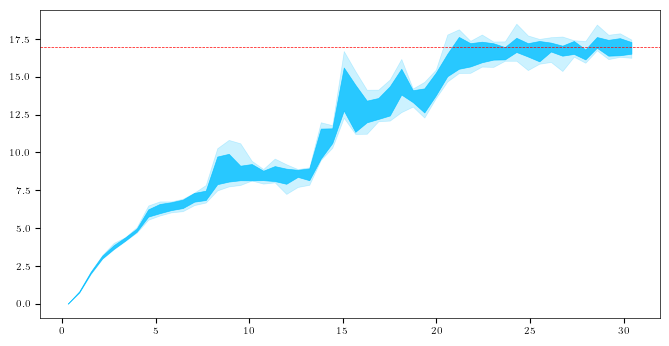

In [71]:
fig, ax = plt.subplots(figsize=(8,4))
plot_quantiles(-logXs, d_Gs, samples.d_G(), ax=ax)

# 32-d Gaussian

In [181]:
name, samples = get_samples('gauss_32')
model = EndModel(samples)
true_endpoint = endpoints[name]
logXf_true = samples.logX().iloc[true_endpoint]

In [182]:
N_points = 50
Nset = 25
iterations = make_iterations(true_endpoint, N_points)
logXs = samples.logX().iloc[iterations]

In [212]:
def get_d_Gs_epsilon(points, ndead):
    beta = get_beta_end(points, ndead)
    d_G = points.d_G(Nset, beta=beta)
    return d_G.values, ""

In [183]:
logXfs, d_Gs = np.zeros((len(iterations), Nset)), np.zeros((len(iterations), Nset))
for i, ndead in enumerate(iterations):
    points = points_at_iteration(samples, ndead)
    beta = get_beta_end(points, ndead, epsilon=0.1)
    points = points.set_beta(beta)
    d_G = points.d_G(Nset)
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(d_G)
    logL, X_mean, nk, logZdead = data(points)
    logXf_set = np.zeros(Nset)
    ds = kde.resample()
    ds = ds[ds > 0]
    for j in range(Nset):
        X = generate_Xs(nk)
        d = np.random.choice(ds)
        theta = params_from_d(logL[ndead:], X[ndead:], d)
        logXf_set[j] = logXf_formula(theta, logZdead, X_mean[ndead])
    logXfs[i], d_Gs[i] = logXf_set, d_G
    print('\r', f"Iteration {ndead} of {iterations[-1]}, d={d_G.mean():.1f}", end='')

/home/zixiao/Documents/III/project/aeons/aeons/regress.py:16: RuntimeWarning: invalid value encountered in scalar divide
  return numerator/denominator


 Iteration 52289 of 52289, d=32.2

In [ ]:
logXfs, d_Gs = model.inferences(get_d_G_grad, iterations, Nset=25)

In [184]:
write_to_txt(f'{data_dir}/d_Gs/term_1/{name}.txt', [iterations, *d_Gs])

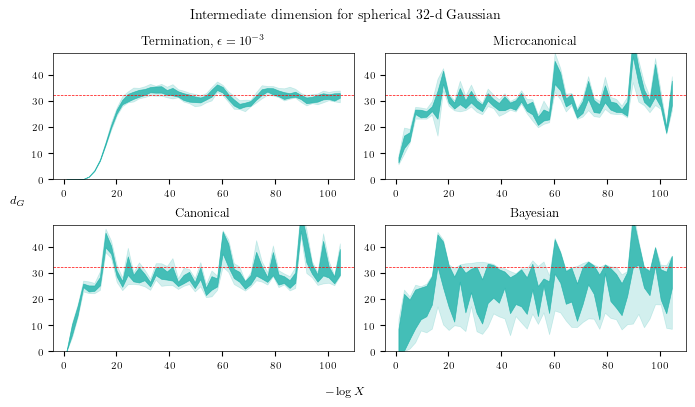

In [204]:
name, samples = get_samples('gauss_32')
fig, axes = plt.subplots(2, 2, figsize=(7, 4))
(ax1, ax2), (ax3, ax4) = axes

iterations_term, *d_Gs_term = read_from_txt(f'{data_dir}/d_Gs/term/{name}.txt')
d_Gs_term = np.array(d_Gs_term)
logXs_term = samples.logX().iloc[iterations_term]
plot_quantiles(-logXs_term, d_Gs_term, samples.d_G(), ylim=(0, 1.5), ax=ax1, color='lightseagreen')

iterations_grad, *d_Gs_grad = read_from_txt(f'{data_dir}/d_Gs/grad/{name}.txt')
d_Gs_grad = np.array(d_Gs_grad)
logXs_grad = samples.logX().iloc[iterations_grad]
plot_quantiles(-logXs_grad, d_Gs_grad, samples.d_G(), ylim=(0, 1.5), ax=ax2, color='lightseagreen')

iterations_logL, *d_Gs_logL = read_from_txt(f'{data_dir}/d_Gs/logL/{name}.txt')
d_Gs_logL = np.array(d_Gs_logL)
logXs_logL = samples.logX().iloc[iterations_logL]
plot_quantiles(-logXs_logL, d_Gs_logL, samples.d_G(), ylim=(0, 1.5), ax=ax3, color='lightseagreen')

iterations_post, *d_Gs_post = read_from_txt(f'{data_dir}/d_Gs/post/{name}.txt')
d_Gs_post = np.array(d_Gs_post)
logXs_post = samples.logX().iloc[iterations_post]
plot_quantiles(-logXs_post, d_Gs_post, samples.d_G(), ylim=(0, 1.5), ax=ax4, color='lightseagreen')

ax1.set_title('Termination, $\\epsilon=10^{-3}$')
ax2.set_title('Microcanonical')
ax3.set_title('Canonical')
ax4.set_title('Bayesian')

fig.supxlabel('$-\log X$')
fig.supylabel('$d_G$', rotation=0)
fig.suptitle('Intermediate dimension for spherical 32-d Gaussian', fontsize=10)
fig.tight_layout()

In [175]:
iterations_post, *d_Gs_post = read_from_txt(f'{data_dir}/d_Gs/post/{name}.txt')
d_Gs_post = np.array(d_Gs_post)
logXs_post = samples.logX().iloc[iterations_post]
plot_quantiles(-logXs_post, d_Gs_post, samples.d_G(), ylim=(0, 1.5), ax=ax1, color='C0')

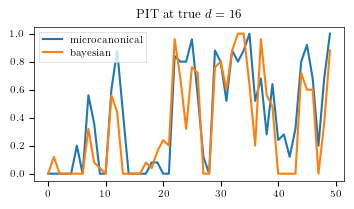

In [184]:
pit_bayes = np.sum(d_Gs_bayes > 16, axis=1)/Nset
pit_grad = np.sum(d_Gs_grad > 16, axis=1)/Nset
plt.plot(pit_grad, label='microcanonical')
plt.plot(pit_bayes, label='bayesian')
plt.title('PIT at true $d = 16$')
plt.legend();

# Elongated 6-d Gaussian

In [205]:
name, samples = get_samples('correlated_6d')
model = EndModel(samples)
true_endpoint = endpoints[name]
logXf_true = samples.logX().iloc[true_endpoint]

In [206]:
N_points = 50
Nset = 25
iterations = make_iterations(true_endpoint, N_points)
logXs = samples.logX().iloc[iterations]

In [207]:
logXfs_grad, d_Gs_grad = model.inferences(get_d_G_grad, iterations, Nset=25)

 Iteration 29635 of 29635, d=6.1

In [213]:
logXfs_post, d_Gs_post = model.inferences(get_d_G_post, iterations, Nset=25)

 Iteration 29635 of 29635, d=6.1

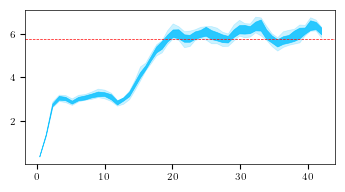

In [210]:
plot_quantiles(-logXs, d_Gs_grad, samples.d_G())

# 32-d Gaussian

In [170]:
name, samples = get_samples('gauss_32')
# samples['beta_logL'] = get_betas_logL(samples)
model = EndModel(samples)
true_endpoint = endpoints[name]
logXf_true = samples.logX().iloc[true_endpoint]

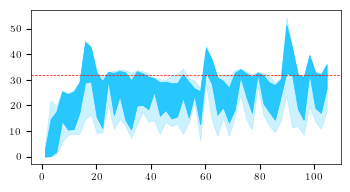

In [172]:
N_points = 50
Nset = 25
iterations = make_iterations(true_endpoint, N_points)
logXfs_bayes, d_Gs_bayes = model.inferences(get_d_G_post, iterations, Nset=Nset)
logXs = samples.logX().iloc[iterations]
plot_quantiles(-logXs, d_Gs_bayes, 32)

 Iteration 52289 of 52289, d=32.2

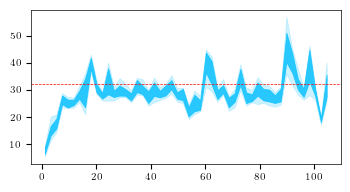

In [173]:
iterations = make_iterations(true_endpoint, N_points)
logXfs_grad, d_Gs_grad = model.inferences(get_d_G_grad, iterations, Nset=Nset)
logXs = samples.logX().iloc[iterations]
plot_quantiles(-logXs, d_Gs_grad, 32)

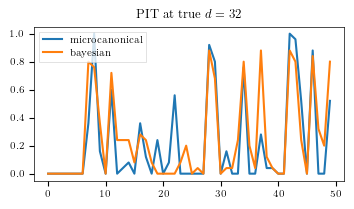

In [180]:
pit_bayes = np.sum(d_Gs_bayes > 32, axis=1)/Nset
pit_grad = np.sum(d_Gs_grad > 32, axis=1)/Nset
plt.plot(pit_grad, label='microcanonical')
plt.plot(pit_bayes, label='bayesian')
plt.title('PIT at true $d = 32$')
plt.legend();

# 64-d Gaussian

In [185]:
name, samples = get_samples('gauss_64')
model = EndModel(samples)
true_endpoint = endpoints[name]
logXf_true = samples.logX().iloc[true_endpoint]

 Iteration 27856 of 88940, d=34.0

/home/zixiao/Documents/III/project/aeons/aeons/regress.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/n * logsum + 1/(2*n*sigma_squared_analytic(d, X_i, logL_i)) * sum_X_2d
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:167: RuntimeWarning: divide by zero encountered in scalar divide
  loglive = loggamma(d/2) + np.log(gammainc(d/2, Xi**(2/d)/(2*sigma**2)) )
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:168: RuntimeWarning: divide by zero encountered in log
  logdead = logZdead - logLmax - (d/2)*np.log(2) - d*np.log(sigma) + np.log(2/d)
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:168: RuntimeWarning: invalid value encountered in scalar subtract
  logdead = logZdead - logLmax - (d/2)*np.log(2) - d*np.log(sigma) + np.log(2/d)


 Iteration 33246 of 88940, d=35.3

/home/zixiao/Documents/III/project/aeons/aeons/regress.py:16: RuntimeWarning: invalid value encountered in scalar divide
  return numerator/denominator


 Iteration 88940 of 88940, d=34.9

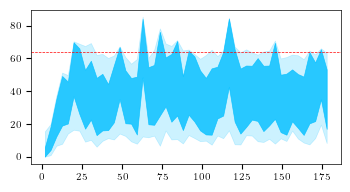

In [212]:
N_points = 50
Nset = 100
iterations = make_iterations(true_endpoint, N_points)
logXfs_bayes, d_Gs_bayes = model.inferences(get_d_G_post, iterations, Nset=Nset)
logXs = samples.logX().iloc[iterations]
plot_quantiles(-logXs, d_Gs_bayes, 64)

In [218]:
write_to_txt('inferences_bayes_gauss_64.txt')

[array([  907.,  2703.,  4500.,  6297.,  8093.,  9890., 11686., 13483.,
        15280., 17076., 18873., 20669., 22466., 24263., 26059., 27856.,
        29652., 31449., 33246., 35042., 36839., 38635., 40432., 42228.,
        44025., 45822., 47618., 49415., 51211., 53008., 54805., 56601.,
        58398., 60194., 61991., 63788., 65584., 67381., 69177., 70974.,
        72771., 74567., 76364., 78160., 79957., 81754., 83550., 85347.,
        87143., 88940.]),
 array([-19.29315693]),
 array([0.09100242])]

 Iteration 88940 of 88940, d=40.9

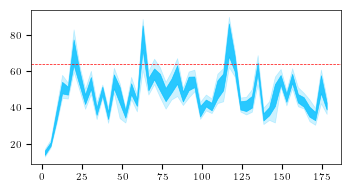

In [213]:
iterations = make_iterations(true_endpoint, N_points)
logXfs_grad, d_Gs_grad = model.inferences(get_d_G_grad, iterations, Nset=Nset)
logXs = samples.logX().iloc[iterations]
plot_quantiles(-logXs, d_Gs_grad, 64)

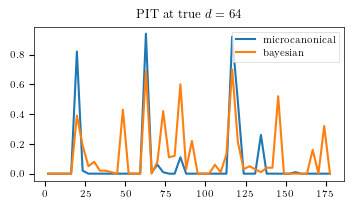

In [214]:
pit_bayes = np.sum(d_Gs_bayes > 64, axis=1)/Nset
pit_grad = np.sum(d_Gs_grad > 64, axis=1)/Nset
plt.plot(-logXs, pit_grad, label='microcanonical')
plt.plot(-logXs, pit_bayes, label='bayesian')
plt.title('PIT at true $d = 64$')
plt.legend();

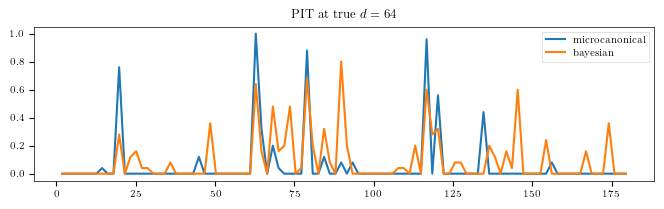

In [207]:
plt.figure(figsize=(8,2))
pit_bayes = np.sum(d_Gs_bayes > 64, axis=1)/Nset
pit_grad = np.sum(d_Gs_grad > 64, axis=1)/Nset
plt.plot(-logXs, pit_grad, label='microcanonical')
plt.plot(-logXs, pit_bayes, label='bayesian')
plt.title('PIT at true $d = 64$')
plt.legend();

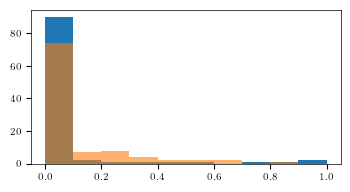

In [205]:
plt.hist(pit_grad, bins=np.linspace(0, 1, 11))
plt.hist(pit_bayes, bins=np.linspace(0, 1, 11), alpha=0.6);